# Verify data between new node and old streams

To do verification:
- run the nsp_all_verify_graph.yaml for 1-2min
- make sure the parameters are same across old pipeline and new one
- stop graph without running the saveRDB derivative
- run this notebook in rt env


In [1]:
import json
import numpy as np
from redis import  Redis
from brand.redis import xread_sync
import matplotlib.pyplot as plt


In [2]:

redis_host = '192.168.30.6'
redis_port = 27263
redis_socket = 10

r = Redis(redis_host, redis_port, retry_on_timeout=True)
r.ping()

supergraph_entry = r.xrevrange(b'supergraph_stream', '+', '-', 1)[0]

In [3]:

print(r.xlen("binned_spikes_old"),r.xlen("binned_spikes_all"))
print(r.xlen("reref_neural_old"),r.xlen("reref_neural_all"))
print(r.xlen("thresh_cross_old"),r.xlen("thresh_cross_all"))


29916 29719
299165 297191
299161 297191


In [4]:
count = 6000
rn_all = r.xread({"reref_neural_all": b'0-0'}, count=count)[0][1]
rn_old = r.xread({"reref_neural_old": b'0-0'}, count=count)[0][1]
tx_all = r.xread({"thresh_cross_all": b'0-0'}, count=count)[0][1]
tx_old = r.xread({"thresh_cross_old": b'0-0'}, count=count)[0][1]
sb_all = r.xread({"sbp_all": b'0-0'}, count=count)[0][1]
sb_old = r.xread({"sbp_old": b'0-0'}, count=count)[0][1]
bs_all = r.xread({"binned_spikes_all": b'0-0'}, count=count)[0][1]
bs_old = r.xread({"binned_spikes_old": b'0-0'}, count=count)[0][1]

In [5]:
nsp_idx_all = np.array([json.loads(tx_all_i[1][b'sync'].decode())['nsp_idx_1'] for tx_all_i in tx_all])
nsp_idx_old = np.array([json.loads(tx_old_i[1][b'sync'].decode())['nsp_idx_1'] for tx_old_i in tx_old])
print(f"Expected num of matches {count - (nsp_idx_all[0] - nsp_idx_old[0])}")

Expected num of matches 4030


In [6]:
nsp_idx_all = np.array([json.loads(tx_all_i[1][b'sync'].decode())['nsp_idx_1'] for tx_all_i in sb_all])
nsp_idx_old = np.array([json.loads(tx_old_i[1][b'sync'].decode())['nsp_idx_1'] for tx_old_i in sb_old])
print(f"Expected num of matches {count - (nsp_idx_all[0] - nsp_idx_old[0])}")

Expected num of matches 4030


In [7]:
def extract_and_compare(all, old, field, dtype, shape, close=False):
    matches = []
    all_s = [np.frombuffer(e[1][field], dtype=dtype).reshape(*shape) for e in all]
    print('Extracted all')
    old_s = [np.frombuffer(e[1][field], dtype=dtype).reshape(*shape) for e in old]
    print('Extracted old')
    for i, a_s in enumerate(all_s):
        if i % 100 == 0:
            print(f'{i/len(all_s)*100:.2f}%, {len(matches)} matches')
        for j, o_s in enumerate(old_s):
            if close and np.isclose(a_s, o_s).all():
                matches.append((j,i))
            elif not close and (a_s == o_s).all():
                matches.append((j,i))
                
    print(f'{len(matches)} matches')

    if len(matches) > 0:
        print('Truncating and stacking')
        all_s = np.hstack(all_s[matches[0][1]:matches[-1][1]+1])
        old_s = np.hstack(old_s[matches[0][0]:matches[-1][0]+1])

    return matches, all_s, old_s

def plot_comparison(all_s, old_s, offset, xlim=None, ch=27):
    fig, ax = plt.subplots(2, 1, figsize=(10,10))
    ax[0].plot(all_s[ch], label='All')
    ax[0].plot(old_s[ch], label='Old')
    if xlim is not None:
        ax[0].set_xlim(*xlim)
    ax[0].legend()
    ax[1].plot(all_s[ch]+offset, label=f'All+{offset}')
    ax[1].plot(old_s[ch], label='Old')
    if xlim is not None:
        ax[1].set_xlim(*xlim)
    ax[1].legend()

Extracted all
Extracted old
0.00%, 0 matches
1.67%, 100 matches
3.33%, 200 matches
5.00%, 300 matches
6.67%, 400 matches
8.33%, 500 matches
10.00%, 600 matches
11.67%, 700 matches
13.33%, 800 matches
15.00%, 900 matches
16.67%, 1000 matches
18.33%, 1100 matches
20.00%, 1200 matches
21.67%, 1300 matches
23.33%, 1400 matches
25.00%, 1500 matches
26.67%, 1600 matches
28.33%, 1700 matches
30.00%, 1800 matches
31.67%, 1900 matches
33.33%, 2000 matches
35.00%, 2100 matches
36.67%, 2200 matches
38.33%, 2300 matches
40.00%, 2400 matches
41.67%, 2500 matches
43.33%, 2600 matches
45.00%, 2700 matches
46.67%, 2800 matches
48.33%, 2900 matches
50.00%, 3000 matches
51.67%, 3100 matches
53.33%, 3200 matches
55.00%, 3300 matches
56.67%, 3400 matches
58.33%, 3500 matches
60.00%, 3600 matches
61.67%, 3700 matches
63.33%, 3800 matches
65.00%, 3900 matches
66.67%, 4000 matches
68.33%, 4026 matches
70.00%, 4026 matches
71.67%, 4026 matches
73.33%, 4026 matches
75.00%, 4026 matches
76.67%, 4026 matches
78.

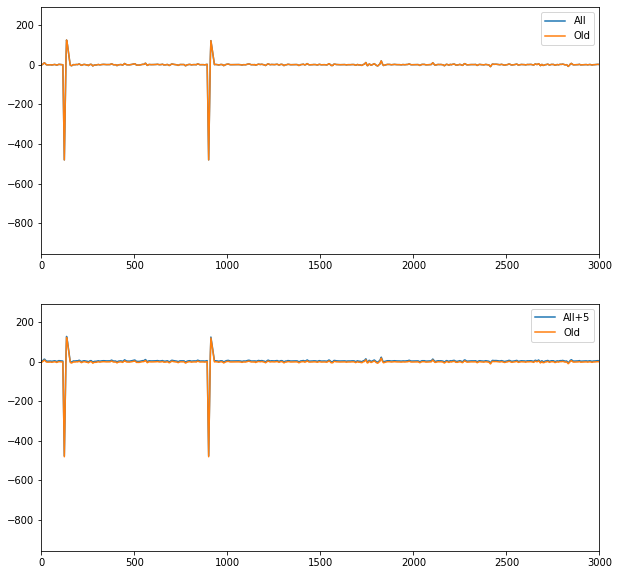

In [8]:
rn_matches, rn_all_s, rn_old_s = extract_and_compare(rn_all, rn_old, b'samples', np.float32, (256, 30))
plot_comparison(rn_all_s, rn_old_s, 5, xlim=(0, 3000))


Extracted all
Extracted old
0.00%, 0 matches
1.67%, 100 matches
3.33%, 200 matches
5.00%, 300 matches
6.67%, 400 matches
8.33%, 500 matches
10.00%, 600 matches
11.67%, 700 matches
13.33%, 800 matches
15.00%, 900 matches
16.67%, 1000 matches
18.33%, 1100 matches
20.00%, 1200 matches
21.67%, 1300 matches
23.33%, 1400 matches
25.00%, 1500 matches
26.67%, 1600 matches
28.33%, 1700 matches
30.00%, 1800 matches
31.67%, 1900 matches
33.33%, 2000 matches
35.00%, 2100 matches
36.67%, 2200 matches
38.33%, 2300 matches
40.00%, 2400 matches
41.67%, 2500 matches
43.33%, 2600 matches
45.00%, 2700 matches
46.67%, 2800 matches
48.33%, 2900 matches
50.00%, 3000 matches
51.67%, 3100 matches
53.33%, 3200 matches
55.00%, 3300 matches
56.67%, 3400 matches
58.33%, 3500 matches
60.00%, 3600 matches
61.67%, 3700 matches
63.33%, 3800 matches
65.00%, 3900 matches
66.67%, 4000 matches
68.33%, 4030 matches
70.00%, 4030 matches
71.67%, 4030 matches
73.33%, 4030 matches
75.00%, 4030 matches
76.67%, 4030 matches
78.

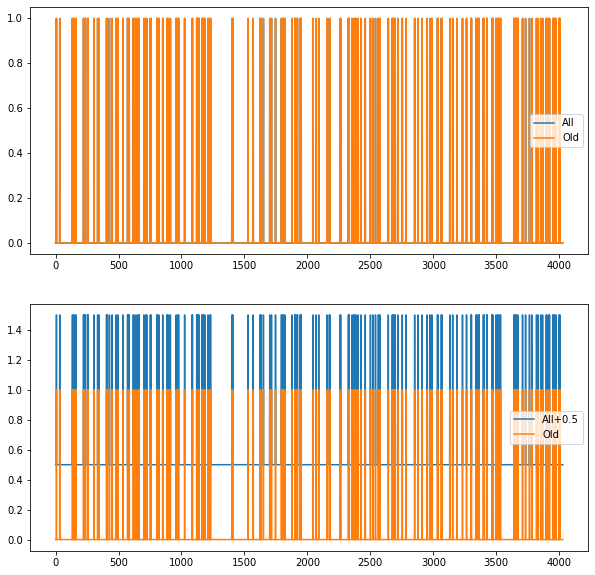

In [9]:
tx_matches, tx_all_s, tx_old_s = extract_and_compare(tx_all, tx_old, b'crossings', np.int16, (256, 1))
plot_comparison(tx_all_s, tx_old_s, 0.5)

Extracted all
Extracted old
0.00%, 0 matches


1.67%, 75 matches
3.33%, 175 matches
5.00%, 275 matches
6.67%, 375 matches
8.33%, 475 matches
10.00%, 575 matches
11.67%, 675 matches
13.33%, 775 matches
15.00%, 875 matches
16.67%, 975 matches
18.33%, 1075 matches
20.00%, 1175 matches
21.67%, 1275 matches
23.33%, 1375 matches
25.00%, 1475 matches
26.67%, 1575 matches
28.33%, 1675 matches
30.00%, 1775 matches
31.67%, 1875 matches
33.33%, 1975 matches
35.00%, 2075 matches
36.67%, 2175 matches
38.33%, 2275 matches
40.00%, 2375 matches
41.67%, 2475 matches
43.33%, 2575 matches
45.00%, 2675 matches
46.67%, 2775 matches
48.33%, 2875 matches
50.00%, 2975 matches
51.67%, 3075 matches
53.33%, 3175 matches
55.00%, 3275 matches
56.67%, 3375 matches
58.33%, 3475 matches
60.00%, 3575 matches
61.67%, 3675 matches
63.33%, 3775 matches
65.00%, 3875 matches
66.67%, 3975 matches
68.33%, 4005 matches
70.00%, 4005 matches
71.67%, 4005 matches
73.33%, 4005 matches
75.00%, 4005 matches
76.67%, 4005 matches
78.33%, 4005 matches
80.00%, 4005 matches
81.67%, 

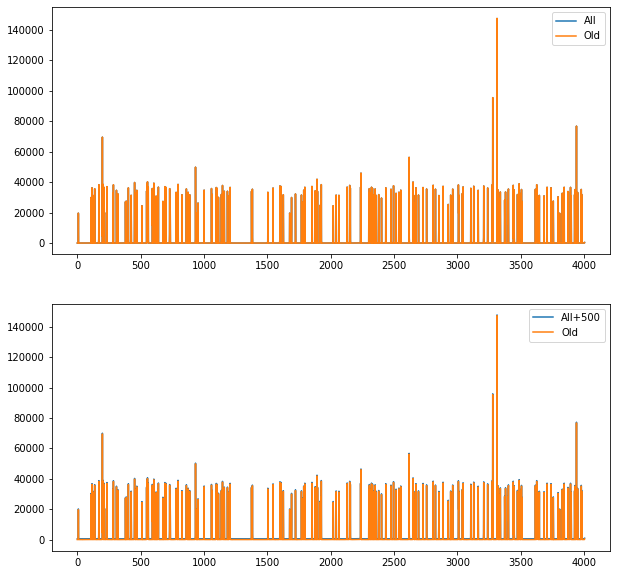

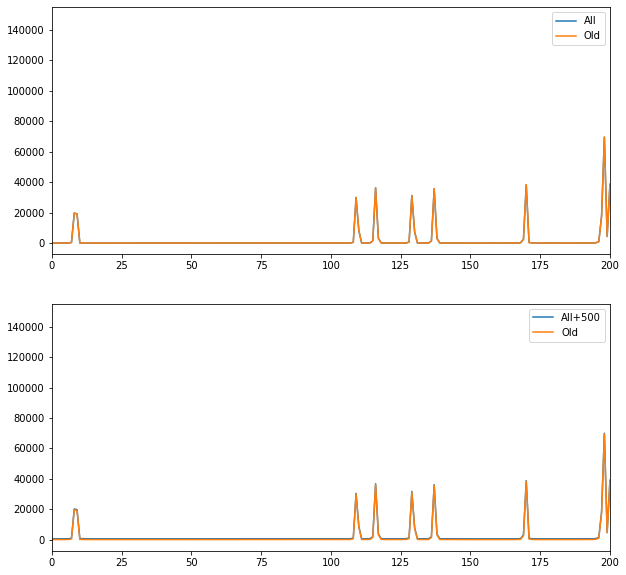

In [10]:
sb_matches, sb_all_s, sb_old_s = extract_and_compare(sb_all, sb_old, b'samples', np.float32, (256, 1), close=True)
plot_comparison(sb_all_s, sb_old_s, 500)
plot_comparison(sb_all_s, sb_old_s, 500, xlim=(0, 200))

In [11]:
# binning might not match as the alignment be off by a few bins
bs_matches, bs_all_s, bs_old_s = extract_and_compare(bs_all, bs_old, b'samples', np.float32, (512, 1), close=True)
if len(bs_matches) > 0:
    plot_comparison(bs_all_s, bs_old_s, 500)
else:
    print('No matches found')

Extracted all
Extracted old
0.00%, 0 matches
1.67%, 0 matches
3.33%, 0 matches
5.00%, 0 matches
6.67%, 0 matches
8.33%, 0 matches
10.00%, 0 matches
11.67%, 0 matches
13.33%, 0 matches
15.00%, 0 matches
16.67%, 0 matches
18.33%, 0 matches
20.00%, 0 matches
21.67%, 0 matches
23.33%, 0 matches
25.00%, 0 matches
26.67%, 0 matches
28.33%, 0 matches
30.00%, 0 matches
31.67%, 0 matches
33.33%, 0 matches
35.00%, 0 matches
36.67%, 0 matches
38.33%, 0 matches
40.00%, 0 matches
41.67%, 0 matches
43.33%, 0 matches
45.00%, 0 matches
46.67%, 0 matches
48.33%, 0 matches
50.00%, 0 matches
51.67%, 0 matches
53.33%, 0 matches
55.00%, 0 matches
56.67%, 0 matches
58.33%, 0 matches
60.00%, 0 matches
61.67%, 0 matches
63.33%, 0 matches
65.00%, 0 matches
66.67%, 0 matches
68.33%, 0 matches
70.00%, 0 matches
71.67%, 0 matches
73.33%, 0 matches
75.00%, 0 matches
76.67%, 0 matches
78.33%, 0 matches
80.00%, 0 matches
81.67%, 0 matches
83.33%, 0 matches
85.00%, 0 matches
86.67%, 0 matches
88.33%, 0 matches
90.00%

In [12]:
# verify threshold crossing and spike band power
# Prints number of matching packets
cnt=0
offset = nsp_idx_all[0] - nsp_idx_old[0]
for i in range(count-offset):
    idx,tx_old_data =tx_old[offset+i]
    idx,tx_all_data = tx_all[i]
    idx,sb_old_data =sb_old[offset+i]
    idx,sb_all_data = sb_all[i]

    p_old=np.frombuffer(sb_old_data[b'samples'],dtype=np.float32)
    p_all=np.frombuffer(sb_all_data[b'samples'],dtype=np.float32)
    c_old=np.frombuffer(tx_old_data[b'crossings'],dtype=np.int16)
    c_all=np.frombuffer(tx_all_data[b'crossings'],dtype=np.int16)

    if   np.all(np.isclose(p_old,p_all)) and np.all(np.isclose(c_old,c_all)):cnt+=1
if cnt:
    print(f"Matched/Expected = {cnt}/{count-offset}")

Matched/Expected = 4005/4030


In [13]:
# computes binned thresholds using old an new thresholds and compares them 
buffer_num=0
cross_bin_buffer_old= np.zeros((256,count-offset),np.int16)
cross_bin_buffer_all = np.zeros((256,count-offset),np.int16)

for i in range(count-offset):
    cross_bin_buffer_old[:, i] = np.frombuffer(tx_old[offset+i][1][b'crossings'],dtype=np.int16)
    cross_bin_buffer_all[:, i] = np.frombuffer(tx_all[i][1][b'crossings'],dtype=np.int16)


print(f"Does binning from old and new threshold streams match? \n{np.all(cross_bin_buffer_old.sum(axis=1) == cross_bin_buffer_all.sum(axis=1))}")


Does binning from old and new threshold streams match? 
True


reref_neural num large ts: 59431/297190


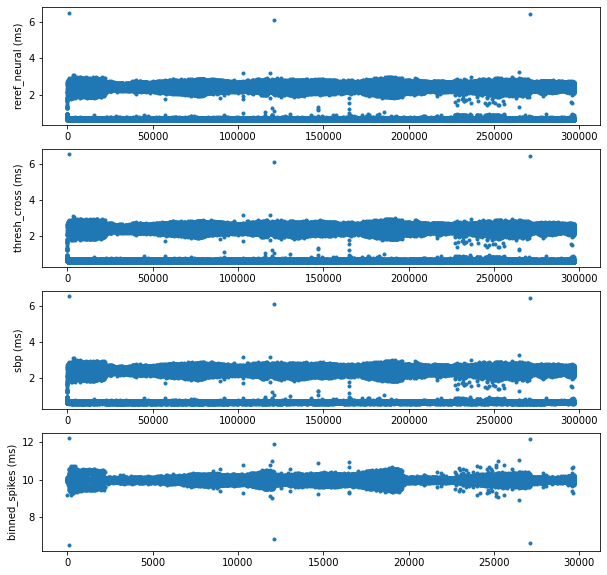

In [14]:
# plot timing

rn = r.xrange("reref_neural_all")
tx = r.xrange("thresh_cross_all")
sb = r.xrange("sbp_all")
bs = r.xrange("binned_spikes_all")

rn_all_t = np.array([np.frombuffer(e[1][b'BRANDS_time'], dtype=np.uint64) for e in rn]).squeeze() / 1e6
tx_all_t = np.array([np.frombuffer(e[1][b'ts'], dtype=np.uint64) for e in tx]).squeeze() / 1e6
sb_all_t = np.array([np.frombuffer(e[1][b'ts'], dtype=np.uint64) for e in sb]).squeeze() / 1e6
bs_all_t = np.array([np.frombuffer(e[1][b'ts'], dtype=np.uint64) for e in bs]).squeeze() / 1e6

fig, ax = plt.subplots(4, 1, figsize=(10,10))
ax[0].plot(np.diff(rn_all_t), '.')
ax[0].set_ylabel('reref_neural (ms)')
ax[1].plot(np.diff(tx_all_t), '.')
ax[1].set_ylabel('thresh_cross (ms)')
ax[2].plot(np.diff(sb_all_t), '.')
ax[2].set_ylabel('sbp (ms)')
ax[3].plot(np.diff(bs_all_t), '.')
ax[3].set_ylabel('binned_spikes (ms)')
fig.patch.set_facecolor('white')

print(f"reref_neural num large ts: {np.sum(np.diff(rn_all_t) > 1.2)}/{len(rn_all_t)-1}")

# Run node and get timing

In [14]:
from nsp_all import NSP_all
import matplotlib.pyplot as plt
import numpy as np

SyntaxError: invalid syntax (4136052359.py, line 1)

In [15]:
import sys
sys.argv = ['tx', '-n', 'nsp_alll', '-i', '192.168.30.6', '-p', '27263']

params = {
    "input_stream": "nsp_neural",
    "output_reref_stream": False,
    "reref_maxlen": 2000,
    "coefs_stream_name": "rereference_parameters",
    "reref_stream_idx": 0,
    "thresh_cross_stream_idx": 1,
    "band_power_stream_idx": 2,
    "binned_spikes_stream_idx": 3,
    "output_streams": ["reref_neural_a", "thresh_cross_a", "sbp_a", "binned_spikes_a"],
    "sync_key": ["tracking_id", "sync", "sync", "sync"],
    "ts_key": ["BRANDS_time", "ts", "ts", "ts"],
    "use_tracking_id": True,
    "td_type": "uint64",
    "sync_dict_key": "nsp_idx_1",
    "filt_stream": None,
    "adaptive_rms_stream": None,
    "pack_per_call": 1,
    "thresh_mult": -4.5,
    "thresh_calc_len": 2000,
    "butter_lowercut": 250,
    "butter_uppercut": None,
    "butter_order": 4,
    "enable_CAR": False,
    "output_filtered": False,
    "acausal_filter_lag": 120,
    "acausal_filter": "IIR",
    "ch_mask_stream": "z_mask_stream",
    "bandpower_logscale": False,
    "chan_per_stream": 256,  # Preserved as string since it's a reference
    "samp_per_stream": 30,
    "chan_total": 256,  # Preserved as string since it's a reference
    "start_channel": 0,
    "samp_freq": 30000,
    "output_dtype": "float32",
    "total_channels": "*total_features",  # Preserved as string since it's a reference
    "bin_size": 10,
    "bin_enable": True
}

node = NSP_all(params)

NameError: name 'NSP_all' is not defined

In [ ]:
node.run()

In [5]:
node.profiler.print_stats()


Timing Statistics (in milliseconds):
--------------------------------------------------------------------------------
Operation                            Mean        Min        Max      Count
--------------------------------------------------------------------------------
INIT                                8.757      8.757      8.757          1
Redis read                          0.475      0.075      1.747      67557
Re-referencing                      0.101      0.099      0.237      67557
Filtering                           0.262      0.253      0.724      67553
Threshold crossing                  0.021      0.019      0.278      67553
Spike band power                    0.004      0.004      0.050      67553
Total Exec Time                     0.445      0.429      0.997      67553
Redis write                         0.132      0.113      0.683      67553
Total Time                          1.000      0.582      2.279      67553
Binning                             0.002      0.0

# Rough

In [ ]:
input_streams= ["thresh_cross_old", "sbp_old"]
stream_dict = {name.encode(): '$' for name in input_streams}
streams = xread_sync(r,stream_dict,block=0,
                        sync_field=b'timestamps',
                        sync_dtype='uint64',
                        count=10)
in_field={b"thresh_cross_old":b"crossings", b"sbp_old":b"samples"}
in_dtype={b"thresh_cross_old":np.dtype("int16"), b"sbp_old":np.dtype("float32")}
window =np.zeros((256,10),dtype=np.float32)


sync_entries = []
sync_entries_stream_dump={}
for stream in streams:
    stream_name, stream_entries = stream
    field = in_field[stream_name]
    in_type = in_dtype[stream_name]
    sync_entries_stream = []
    synx=[]
    for i, (entry_id, entry_dict) in enumerate(stream_entries):
        # load the input
        window[:, i] = np.frombuffer(entry_dict[field],
                                            dtype=in_type).astype(
                                                'float32')
        # log sync for this entry
        sync_entries_stream.append(
            json.loads(entry_dict[b'sync'].decode()))
        synx.append(json.loads(entry_dict[b'sync'].decode()))
    sync_entries_stream_dump[stream_name.decode()]=synx
    sync_entries.append(sync_entries_stream)
    # update the xread ID
    stream_dict[stream_name] = entry_id

# create sync dict from sync entries from input streams
sync_dict = {}
for stream in sync_entries:
    sync_entry_dict = stream[0]  # first entry from each stream
    for key in sync_entry_dict:
        sync_dict[key] = sync_entry_dict[key]
sync_dict_json = json.dumps(sync_dict)

In [46]:
# verify threshold crossing and binned threshould_crossing

cnt=0
for i in range(1000):
    idx,tx4_data =tx4[i]
    idx,txa_data = txa[i]
    idx,sb4_data =sb4[i]
    idx,sba_data = sba[i]
    idx,bs4_data =bs4[i]
    idx,bsa_data = bsa[i]
    p4=np.frombuffer(sb4_data[b'samples'],dtype=np.float32)
    pa=np.frombuffer(sba_data[b'samples'],dtype=np.float32)
    c4=np.frombuffer(tx4_data[b'crossings'],dtype=np.int16)
    ca=np.frombuffer(txa_data[b'crossings'],dtype=np.int16)
    b4=np.frombuffer(bs4_data[b'samples'],dtype=np.float32)[:256]
    ba=np.frombuffer(bsa_data[b'samples'],dtype=np.float32)[:256]
    if np.all(np.isclose(b4,ba)) and not np.all(np.isclose(p4,pa)) and np.all(np.isclose(c4,ca)):cnt+=1
if cnt:
    print(cnt)

995


In [59]:
tx_old_data

{b'sync': b'{"nsp_idx_1": 1000}',
 b'timestamps': b'\xe8\x03\x00\x00\x00\x00\x00\x00',
 b'crossings': b'\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00